## Library and Data Imports

In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# read local csv files and put into data frames
data_url = '17zpallnoagi.csv'
zpallnoagi_csv = pd.read_csv(data_url)
raw_tax_df = pd.DataFrame(zpallnoagi_csv)
display(raw_tax_df)
mhi_data_url = 'MarketHealthIndex_Zip.csv'
market_health_csv = pd.read_csv(mhi_data_url, on_bad_lines='skip', encoding = "ISO-8859-1")
market_health_df = pd.DataFrame(market_health_csv)

,STATEFIPS,STATE,ZIPCODE,AGI_STUB,N1,MARS1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,1,AL,0,0,2033660.0,841450.0,748460.0,402300.0,1825940.0,106040.0,...,31890.0,112620.0,382910.0,1842204.0,1608610.0,5145662.0,1579020.0,4641848.0,32240.0,447705.0
1,1,AL,35004,0,5130.0,2140.0,2120.0,780.0,4660.0,270.0,...,30.0,32.0,970.0,2693.0,4090.0,11048.0,4020.0,10706.0,70.0,308.0
2,1,AL,35005,0,3170.0,1350.0,870.0,900.0,2840.0,150.0,...,0.0,0.0,450.0,964.0,2660.0,7591.0,2640.0,7552.0,0.0,0.0
3,1,AL,35006,0,1210.0,440.0,580.0,170.0,1120.0,50.0,...,0.0,0.0,190.0,466.0,990.0,2822.0,990.0,2812.0,0.0,0.0
4,1,AL,35007,0,11930.0,4720.0,5180.0,1790.0,10270.0,990.0,...,110.0,90.0,2720.0,9363.0,8960.0,24472.0,8840.0,23758.0,150.0,664.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27755,56,WY,83126,0,180.0,60.0,110.0,0.0,170.0,0.0,...,0.0,0.0,40.0,96.0,130.0,351.0,130.0,338.0,0.0,0.0
27756,56,WY,83127,0,1550.0,500.0,890.0,90.0,1290.0,120.0,...,40.0,95.0,460.0,2809.0,1040.0,2934.0,980.0,2594.0,80.0,275.0
27757,56,WY,83128,0,950.0,480.0,400.0,60.0,820.0,90.0,...,30.0,164.0,270.0,1285.0,670.0,4016.0,620.0,1774.0,50.0,1440.0
27758,56,WY,83414,0,220.0,80.0,130.0,0.0,210.0,0.0,...,30.0,246.0,60.0,830.0,130.0,1161.0,120.0,645.0,30.0,1670.0


## Data Cleaning and Imputation

### Downselection of Features

In [3]:
# Columns used for both sets
market_health_cols = ['RegionName','MarketHealthIndex','SellForGain','ForeclosureRatio','NegativeEquity','Delinquency',
                      'DaysOnMarket','ZHVI']

zip_tax_cols = ['ZIPCODE','MARS1','MARS2','MARS4','NUMDEP','A00100','N02650', 'A02650','A00200','A00300', 'A00900',
                'A01000','A01700','SCHF','A02300','A02500','N26270','N03220','A03300','N03150','N03210','N03230',
                'A17000','A18425','A18500','A19300','N19570','A19700','A20950','N04800','A04800','A07300','N07180',
                'A07180','N07220','A07220','N09400','A09400','A10600','N11070','A11070','N06500','A06500','A85300']

# filtered and merged together raw data sets 
tax_zip_df = raw_tax_df.filter(zip_tax_cols)
mh_df = market_health_df.filter(market_health_cols, axis=1)
merged_df = pd.merge(tax_zip_df, mh_df, left_on="ZIPCODE", right_on="RegionName")
# meaned out rows with same zip code and dropped the duplicate RegionName / zip field
# grouped_df = merged_df.groupby('zipcode').mean().reset_index()
grouped_df = merged_df.drop(columns=['RegionName'])
# most simpliest data frame
display(grouped_df)


,ZIPCODE,MARS1,MARS2,MARS4,NUMDEP,A00100,N02650,A02650,A00200,A00300,...,N06500,A06500,A85300,MarketHealthIndex,SellForGain,ForeclosureRatio,NegativeEquity,Delinquency,DaysOnMarket,ZHVI
0,35004,2140.0,2120.0,780.0,3350.0,289966.0,5130.0,292671.0,236776.0,902.0,...,3870.0,27796.0,32.0,4.893179,NaN,NaN,0.092712,0.026738,76.0,147100.0
1,35005,1350.0,870.0,900.0,2230.0,124916.0,3170.0,125810.0,102620.0,261.0,...,2010.0,9187.0,0.0,0.887927,40.00,2.9443,0.250780,0.082988,80.0,75000.0
2,35006,440.0,580.0,170.0,820.0,59411.0,1210.0,59725.0,46012.0,106.0,...,870.0,5089.0,0.0,6.796082,NaN,NaN,0.221277,0.019231,84.0,78500.0
3,35007,4720.0,5180.0,1790.0,8840.0,706211.0,11930.0,714402.0,555765.0,1832.0,...,8520.0,72973.0,90.0,5.600114,84.62,0.6175,0.066375,0.037618,55.0,157700.0
4,35010,3000.0,2710.0,2060.0,5850.0,387333.0,7890.0,391523.0,262452.0,3394.0,...,4740.0,37697.0,688.0,6.150898,NaN,NaN,0.192933,0.017442,147.0,105300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13998,54970,650.0,560.0,150.0,630.0,57723.0,1360.0,58115.0,43406.0,223.0,...,940.0,4676.0,0.0,3.277734,NaN,NaN,0.170391,0.016393,125.0,111500.0
13999,54971,2660.0,2100.0,450.0,2490.0,288010.0,5230.0,292186.0,206390.0,1779.0,...,3870.0,30295.0,252.0,6.104053,NaN,NaN,0.071623,0.028571,80.0,127100.0
14000,54974,330.0,380.0,50.0,430.0,45633.0,780.0,46312.0,35437.0,98.0,...,640.0,4240.0,0.0,6.771240,NaN,NaN,0.060201,0.000000,80.0,160400.0
14001,54979,340.0,380.0,50.0,350.0,45874.0,770.0,46668.0,34219.0,107.0,...,620.0,4493.0,0.0,8.254667,NaN,NaN,0.050000,0.000000,70.0,176000.0


### Splitting Training and Holdout Data

Only training data will be used for Exploratory Data Analysis

In [4]:
# splitting data 
# df_eda is 80% of random data, df_holdout is 20% of the remaining data
df_eda, df_holdout = train_test_split(grouped_df, test_size=0.20, random_state=22)
print("80% of grouped_df", .8 * len(grouped_df))
print("len of df_eda", len(df_eda))
display(df_eda)

80% of grouped_df 11202.400000000001
len of df_eda 11202


,ZIPCODE,MARS1,MARS2,MARS4,NUMDEP,A00100,N02650,A02650,A00200,A00300,...,N06500,A06500,A85300,MarketHealthIndex,SellForGain,ForeclosureRatio,NegativeEquity,Delinquency,DaysOnMarket,ZHVI
9140,13850,4710.0,4340.0,710.0,5100.0,806571.0,9940.0,818461.0,517408.0,5937.0,...,7780.0,113416.0,916.0,2.586415,81.82,NaN,0.101289,0.066667,92.0,128500.0
5412,20616,1690.0,920.0,800.0,2500.0,238866.0,3550.0,239927.0,202262.0,329.0,...,2740.0,23869.0,15.0,5.138051,100.00,NaN,0.244229,0.097561,93.5,263200.0
5885,1566,1640.0,1540.0,240.0,1790.0,315416.0,3480.0,318920.0,233627.0,1759.0,...,2880.0,46088.0,189.0,6.323373,100.00,NaN,0.085440,0.081633,76.0,274200.0
4476,46815,6620.0,4850.0,1710.0,7980.0,659101.0,13410.0,666299.0,489028.0,3480.0,...,9400.0,61711.0,161.0,2.110867,NaN,NaN,0.057726,0.047138,49.0,117400.0
12991,23223,13650.0,3550.0,6570.0,14020.0,1010689.0,24430.0,1021980.0,844452.0,1532.0,...,15710.0,99345.0,183.0,2.631840,76.47,6.3815,0.163589,0.034208,63.0,140900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5478,20764,1050.0,790.0,230.0,1060.0,170241.0,2140.0,172263.0,123188.0,1039.0,...,1730.0,21576.0,98.0,0.962453,66.67,2.1673,0.094488,0.154762,84.0,297200.0
8548,11420,10820.0,6310.0,5870.0,14790.0,1017704.0,23560.0,1025701.0,865399.0,2268.0,...,15380.0,84131.0,102.0,9.148272,100.00,NaN,0.059478,0.244604,173.5,482700.0
13100,24087,680.0,650.0,200.0,880.0,71298.0,1570.0,71990.0,56248.0,154.0,...,1080.0,6466.0,0.0,1.754560,NaN,NaN,0.071685,0.050000,71.0,152600.0
6276,48140,680.0,750.0,120.0,890.0,104425.0,1580.0,105704.0,77579.0,388.0,...,1230.0,11714.0,0.0,3.716374,NaN,NaN,0.080769,0.000000,81.0,164600.0


### Imputation of Missing Values

In [5]:
# First remove rows missing the target variable of ZHVI
df_eda = df_eda[df_eda['ZHVI'].notna()]

# Split the data into input and target
train_X = df_eda.drop(columns=['ZHVI'])
train_y = df_eda['ZHVI']

print('train_X shape:', train_X.shape)
print('train_y shape:', train_y.shape)

# Display the missing values
missing_values = train_X.isnull().sum()
missing_values = missing_values[missing_values > 0]

cols = ['Feature', 'Number Missing', 'Percent Missing']
missing_df = pd.DataFrame(columns=cols)
for col in missing_values.index:
    missing_df.loc[len(missing_df.index)] = {'Feature': col,
                                    'Number Missing': missing_values[col],
                                    'Percent Missing': missing_values[col] / len(df_eda) * 100}

pd.set_option('display.float_format', '{:.1f}'.format)
display(missing_df)

# Impute missing values using KNN
imputer = KNNImputer(n_neighbors=5)

imputed_values = imputer.fit_transform(train_X)

# Convert the numpy array back into a dataframe
train_X = pd.DataFrame(imputed_values, columns=train_X.columns)

missing_values_after = train_X.isnull().sum()
print('\nTotal missing values after imputation:')
print(missing_values_after[missing_values_after > 0])




train_X shape: (11090, 50)
train_y shape: (11090,)


,Feature,Number Missing,Percent Missing
0,SellForGain,3645,32.9
1,ForeclosureRatio,8581,77.4
2,NegativeEquity,295,2.7
3,Delinquency,295,2.7
4,DaysOnMarket,107,1.0



Total missing values after imputation:
Series([], dtype: int64)


## Exploratory Data Analysis

### Distribution of Key Features and Target Variable

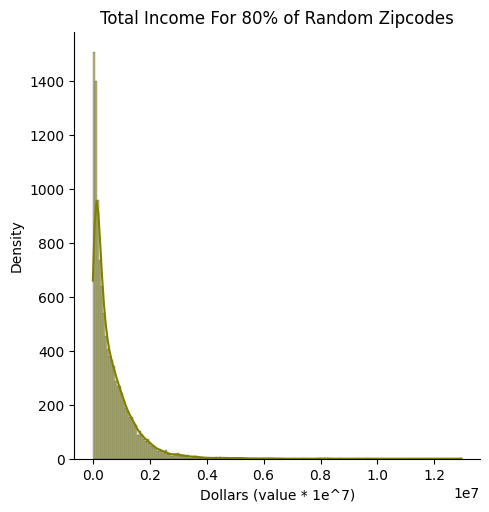

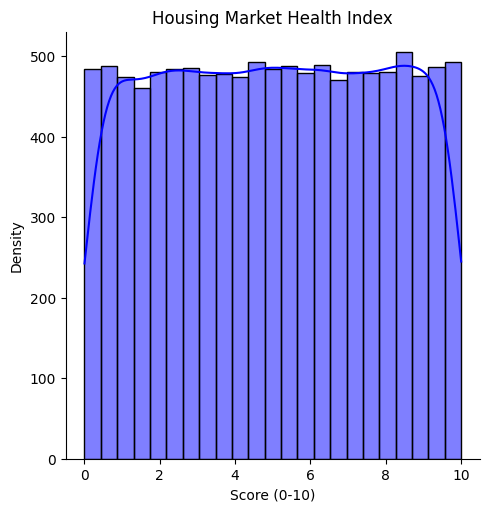

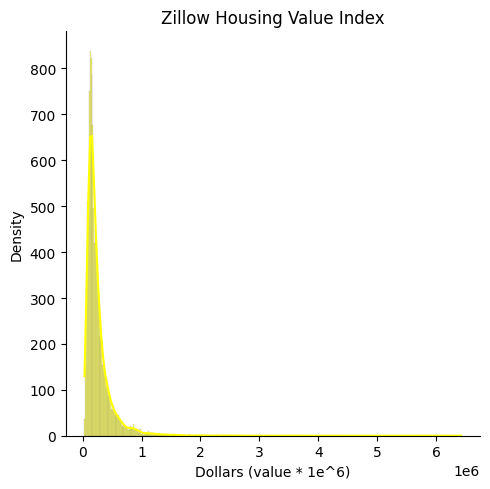

In [6]:
# different graphical display of data

# sns.pairplot(df_eda[['A02650', 'MarketHealthIndex', 'ZHVI']])

# two histogram options seperated and together
# together

ax1 = sns.displot(train_X, x=train_X['A02650'],  kde = True, color="olive", label = 'income')
# ax1.set(xticks=(0,9000000))

plt.title('Total Income For 80% of Random Zipcodes')
plt.xlabel('Dollars (value * 1e^7)')
plt.ylabel('Density')


sns.displot(train_X, x=train_X['MarketHealthIndex'], kde = True, color="blue", label = 'market_health_index')

plt.title('Housing Market Health Index')
plt.xlabel('Score (0-10)')
plt.ylabel('Density')

sns.displot(train_y, x=train_y, kde = True, color="yellow", label = 'zillow_housing_value_index')

plt.title('Zillow Housing Value Index')
plt.xlabel('Dollars (value * 1e^6)')
plt.ylabel('Density')

plt.tight_layout()



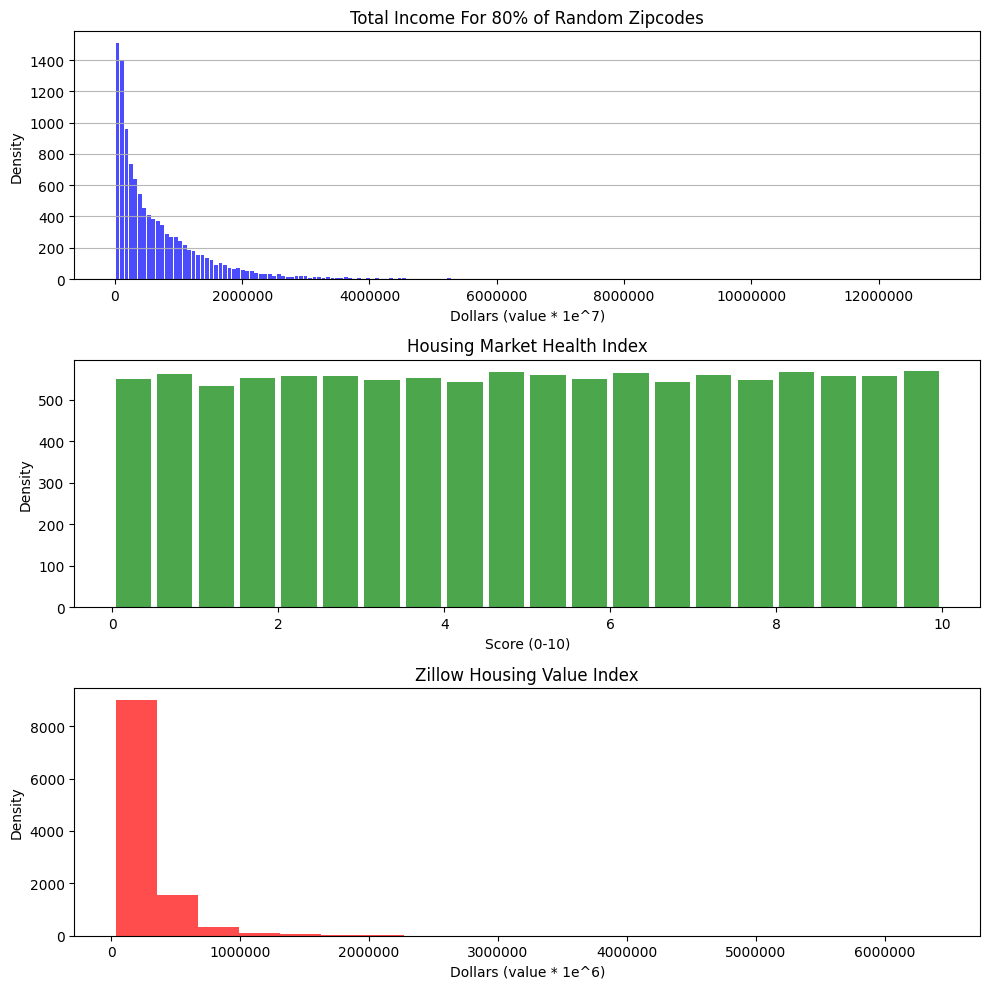

In [7]:
fig, axs = plt.subplots(3, figsize=(10,10))

axs[0].ticklabel_format(axis='both', style='plain')

# Create a histogram for 'income'
axs[0].hist(train_X['A02650'], bins='auto', color='blue', alpha=0.7, rwidth=0.85)
axs[0].grid(axis='y', alpha=0.9)
axs[0].set_title('Total Income For 80% of Random Zipcodes')
axs[0].set_xlabel('Dollars (value * 1e^7)')
axs[0].set_ylabel('Density')

# Create a histogram for 'market_health_index'
axs[1].hist(train_X['MarketHealthIndex'], bins=20, color='green', alpha=0.7, rwidth=0.85)
axs[1].set_title('Housing Market Health Index')
axs[1].set_xlabel('Score (0-10)')
axs[1].set_ylabel('Density')


# Create a histogram for 'zillow_housing_value_index'
axs[2].hist(train_y, bins=20, color='red', alpha=0.7)
axs[2].ticklabel_format(axis='both', style='plain')
axs[2].ticklabel_format(axis='both', style='plain')
axs[2].set_title('Zillow Housing Value Index')
axs[2].set_xlabel("Dollars (value * 1e^6)")
axs[2].set_ylabel("Density")

plt.tight_layout()

### Data Loss from Dataset Merge

In [8]:
available_returns = raw_tax_df.groupby(['STATE']).sum().reset_index()
market_health_zips = market_health_df['RegionName'].tolist()


used_returns = raw_tax_df[raw_tax_df['ZIPCODE'].isin(market_health_zips)]

used_returns = used_returns.groupby(['STATE']).sum().reset_index()


merged_df = pd.merge(available_returns, used_returns, on='STATE', how='inner')

merged_df['Ratio'] = merged_df['N1_y'] / merged_df['N1_x']

print(merged_df.head())

import plotly.express as px

# May need pip install --upgrade nbformat

fig = px.choropleth(merged_df, locations="STATE", color="Ratio", hover_name="STATE", locationmode='USA-states', scope='usa', color_continuous_scale="Viridis")

fig.show()


  STATE  STATEFIPS_x  ZIPCODE_x  AGI_STUB_x       N1_x    MARS1_x    MARS2_x  \
0    AK          110    5380952           0   690610.0   350390.0   249740.0   
1    AL          576   20736287           0  4068620.0  1683950.0  1498020.0   
2    AR         2455   35462259           0  2428630.0  1002100.0   960340.0   
3    AZ         1180   25160457           0  5955380.0  2738520.0  2180910.0   
4    CA         8868  138152636           0 35656240.0 17534890.0 12530350.0   

    MARS4_x      ELF_x   CPREP_x  ...  A85300_y  N11901_y   A11901_y  \
0   74020.0   598630.0   45860.0  ...   15655.0   47680.0   220760.0   
1  805670.0  3653470.0  212930.0  ...   90746.0  270880.0  1390343.0   
2  417010.0  2198070.0  108510.0  ...  278575.0  155880.0   731445.0   
3  956810.0  5232040.0  408960.0  ...  280924.0  647860.0  3204363.0   
4 5073960.0 31315660.0 2617960.0  ... 3775191.0 4156540.0 26776534.0   

    N11900_y   A11900_y   N11902_y   A11902_y  N12000_y   A12000_y  Ratio  
0   151500

## Model Selection

### Final Data Preparation

Split holdout into validation and train sets and perform same data cleaning as training values.
Normalize all inputs. 

In [9]:
# Final data preparation for modeling


# Remove rows missing the target variable of ZHVI
df_holdout = df_holdout[df_holdout['ZHVI'].notna()]

# Split holdout data into validation and test set
val, test = train_test_split(df_holdout, test_size=0.50, random_state=22)

# Split the data into input and target
val_X = val.drop(columns=['ZHVI'])
val_y = val['ZHVI']


test_X = test.drop(columns=['ZHVI'])
test_y = test['ZHVI']

val_imputed_values = imputer.fit_transform(val_X)
test_imputed_values = imputer.fit_transform(test_X)

# Convert the numpy array back into a dataframe
val_X = pd.DataFrame(val_imputed_values, columns=val_X.columns)
test_X = pd.DataFrame(test_imputed_values, columns=test_X.columns)

print(val_X.head())
print(train_X.head())

# Normalize the train_X data
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)

# Normalize the val_X and test_X data
val_X = scaler.transform(val_X.to_numpy())
test_X = scaler.transform(test_X.to_numpy())

#print('first row of train_X after scaling:\n', train_X[0])
print('first row of val_X after scaling:\n', val_X[0])
#print('first row of test_X after scaling:\n', test_X[0])

   ZIPCODE  MARS1  MARS2  MARS4  NUMDEP    A00100  N02650    A02650    A00200  \
0  13339.0 1180.0 1020.0  360.0  1830.0  112286.0  2620.0  113703.0   83664.0   
1  18938.0 3410.0 3270.0  340.0  3210.0 1838641.0  7120.0 1868117.0 1049046.0   
2  57107.0 2740.0 1820.0  650.0  3010.0  292479.0  5300.0  297478.0  226949.0   
3  80236.0 3810.0 2410.0 1160.0  4850.0  382841.0  7550.0  387142.0  287733.0   
4  13648.0  430.0  420.0  100.0   560.0   48907.0   960.0   49259.0   37117.0   

   A00300  ...  A11070  N06500   A06500  A85300  MarketHealthIndex  \
0   389.0  ...   470.0  1730.0   9001.0     0.0                4.1   
1 25914.0  ...   123.0  5670.0 434746.0  9539.0                3.1   
2  1577.0  ...   871.0  4010.0  32849.0   226.0                5.0   
3  1669.0  ...  1379.0  5460.0  36672.0   101.0                8.5   
4   118.0  ...   106.0   740.0   4343.0     0.0                2.5   

   SellForGain  ForeclosureRatio  NegativeEquity  Delinquency  DaysOnMarket  
0         72.1

/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



### Linear Regression

'train X '

(11090, 50)

'train y'

(11090,)

'predict_train'

array([ -79934.3294141 , -115700.05994286,   -1860.52456142, ...,
        -30031.64140835,  -34603.53888171,  -13732.82404714])

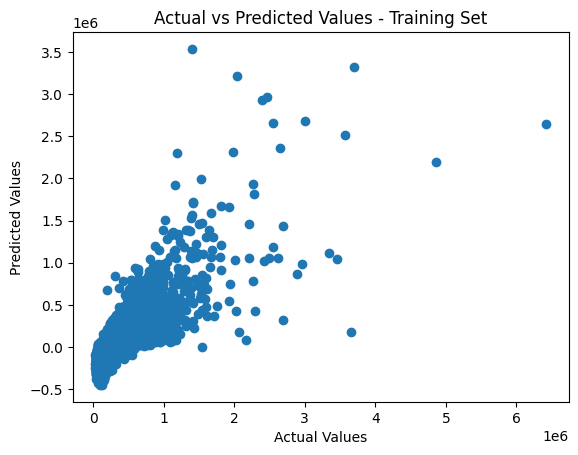

'Off by $297561.43 many dollars'

'val_X len'

1392

'pred val'

array([-106656.35819317,  305588.06287214,  -90056.27302134, ...,
        -12218.62156688,   -9048.5589416 , -142240.55678427])

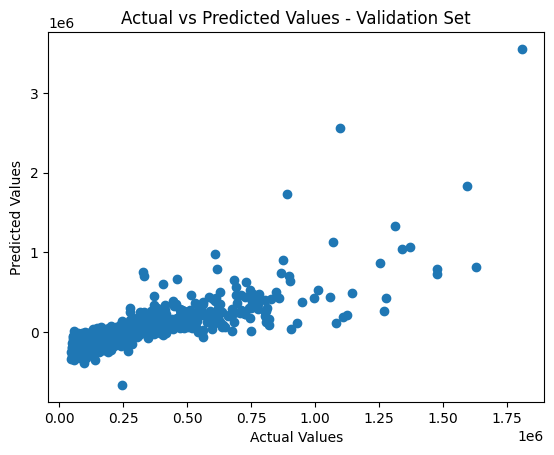

'Off by $286485.79 many dollars'

In [20]:
from sklearn.metrics import mean_squared_error
display('train X ', train_X.shape)
display('train y', train_y.values.shape)
# Running linear regression with a constant on test set
model = sm.OLS(train_y.values, train_X)
results = model.fit()
# Predict
predict_train = results.predict()
display('predict_train', predict_train)
MSE = mean_squared_error(train_y, predict_train)
plt.scatter(train_y, predict_train)
plt.title('Actual vs Predicted Values - Training Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

display(f'Off by ${np.sqrt(MSE):.2f} many dollars')
display('val_X len', len(val_X))
predict_val = results.predict(val_X)
display('pred val', predict_val)
plt.scatter(val_y, predict_val)
plt.title('Actual vs Predicted Values - Validation Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()
MSE = mean_squared_error(val_y, predict_val)
display(f'Off by ${np.sqrt(MSE):.2f} many dollars')

### XGBoost Evaluation

In [11]:
from xgboost import XGBRegressor



### Sequential Neural Network Evaluation

In [12]:
# Constants

BATCH_SIZE = 1
EPOCHS = 10
LR = 0.01

In [13]:
# Model definition
class Model(nn.Module):
    def __init__(self, input_size, output_size=1):
        super().__init__()

        self.hidden_dim = output_size + (input_size - output_size) // 2

        self.fc_1 = nn.Linear(input_size, self.hidden_dim)
        self.fc_2 = nn.Linear(self.hidden_dim, output_size)

    def forward(self, x):

        out = self.fc_1(x)
        out = F.relu(out)
        out = self.fc_2(out)

        return out

model = Model(train_X.shape[1])
print(model)

Model(
  (fc_1): Linear(in_features=50, out_features=25, bias=True)
  (fc_2): Linear(in_features=25, out_features=1, bias=True)
)


Run on GPU if available

In [14]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")

else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

model.to(device)

GPU not available, CPU used


Model(
  (fc_1): Linear(in_features=50, out_features=25, bias=True)
  (fc_2): Linear(in_features=25, out_features=1, bias=True)
)

In [15]:
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [16]:
# Training loop

def training_loop(model, train_X, train_y, num_epochs = 1, batch_size = 1):

    print(train_X.shape)
    print(train_y.shape)

    num_batches = len(train_X) // batch_size

    losses = []
    total_loss = 0

    for epoch in tqdm(range(num_epochs)):  # loop over the dataset for each epoch
        for batch in range(num_batches):
            # get the inputs; data is a list of [inputs, labels]
            start_index = batch * batch_size
            end_index = start_index + batch_size
            inputs = torch.from_numpy(train_X[start_index: end_index]).float().reshape(batch_size, -1)
            inputs.requires_grad = True
            labels = torch.from_numpy(np.asarray(train_y[start_index: end_index])).float().reshape(batch_size, -1)
            labels.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, labels))
            loss.backward()
            # Print the parameter
            print("model.fc_1.weight)
            optimizer.step()

            #print(model.fc_1.weight.grad)
            # Print the optimizer gradients
            #print(optimizer.state_dict()['param_groups'][0]['grad'])

            total_loss += np.mean(loss.item())

            if batch % 10000 == 0:
                print(f'Epoch: {epoch + 1}, Batch: {batch + 1}, Loss: {loss.item()}')
                print(model.fc_1.weight.grad)

        average_loss = total_loss / num_batches
        losses.append(average_loss)
        total_loss = 0  # Reset the total loss for the next epoch
        
    return losses

SyntaxError: unterminated string literal (detected at line 31) (3093572718.py, line 31)

In [ ]:
losses = training_loop(model, train_X, train_y, num_epochs=EPOCHS, batch_size=BATCH_SIZE)

plt.plot(losses)

# Print the weights and biases
print(model.fc_1.weight)
print(model.fc_1.bias)
print(model.fc_2.weight)
print(model.fc_2.bias)